# Artificial Neural Networks and Deep Learning

---

## Homework 2: Semantic Segmentation
This notebook contains one possible structure for the second homework of the AN2DL course. The goal is to perform semantic segmentation on a specific set of images, collected from Mars surface.

## TODO:
* Il test set non presenta particolari augmentations, le immagini sembrano le stesse del train set
* La classe di Background (label = 0) non è inclusa nella valutazione del MeanIoU e pertanto è da escludersi.

* Da questo video (https://www.youtube.com/watch?v=azM57JuQpQI&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE) si nota che viene anche usato un layer di dropout con rate piccolo (0.1) durante la convoluzione: può aiutare?

## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import keras_cv as kcv

from sklearn.model_selection import train_test_split

seed = 42
# np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [2]:
# Load the entire dataset
data = np.load("/kaggle/input/mars-dataset/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## 👀 Inspect the dataset
Dataset inspection is meant to find possible outliers in the images, detect duplicates and, more in general, to do everything connected to data cleaning and pre-processing.

[1243 1644  472  791 1481 1315 1326 1238  223  867]


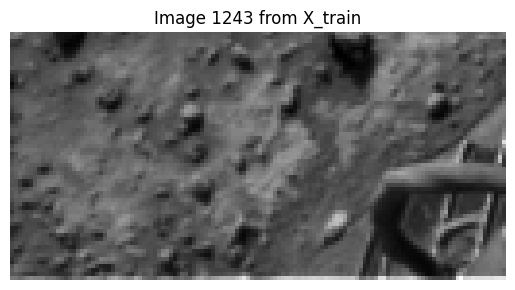

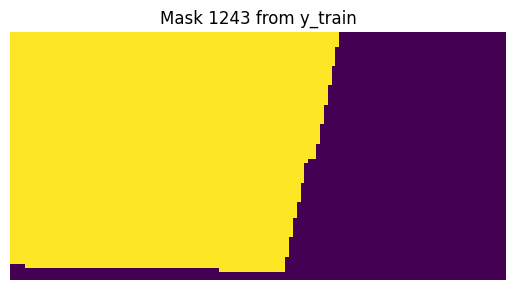

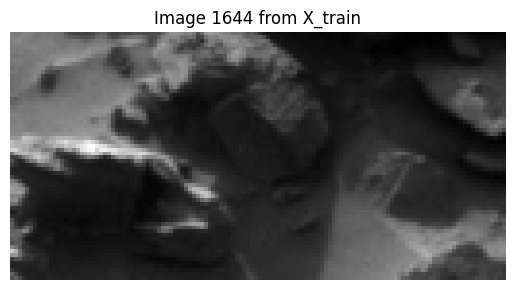

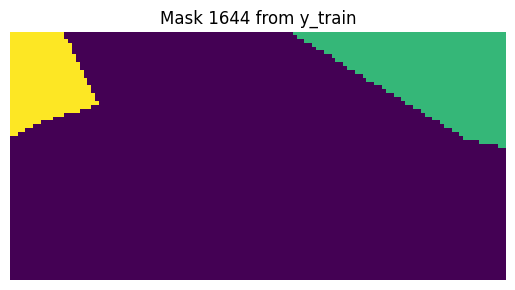

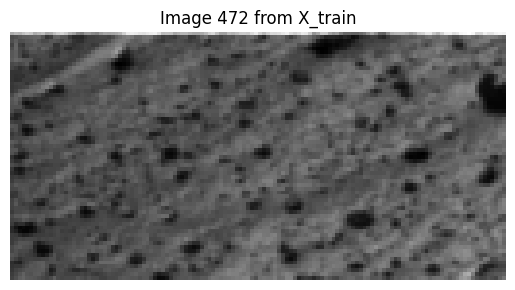

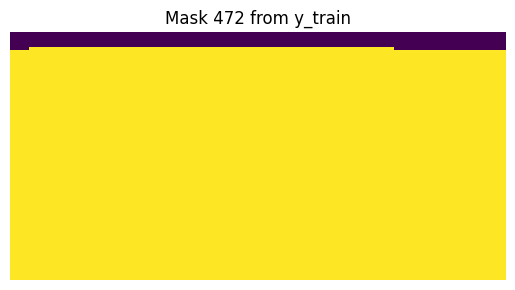

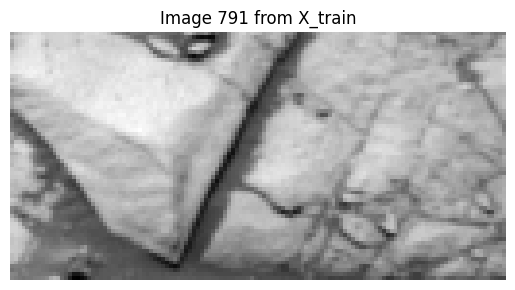

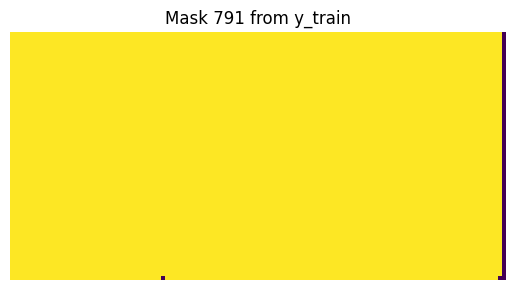

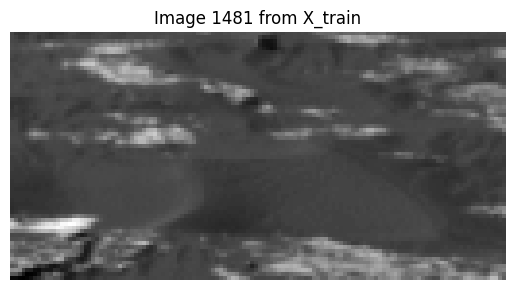

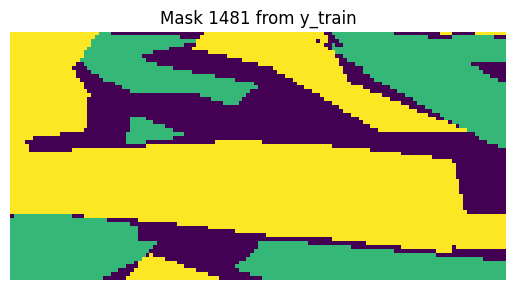

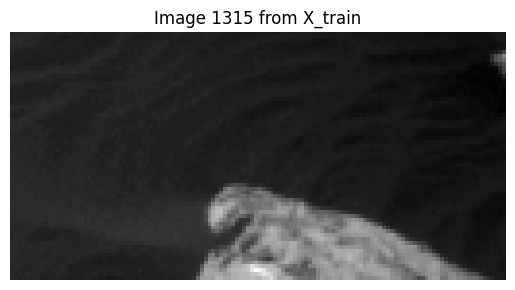

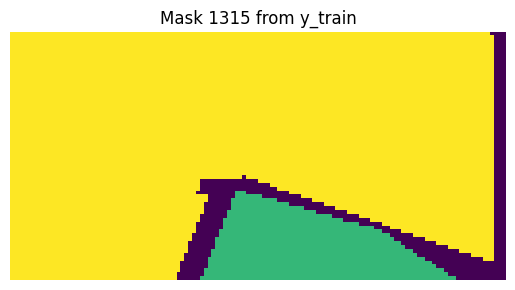

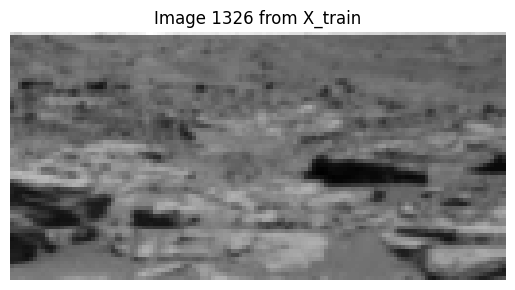

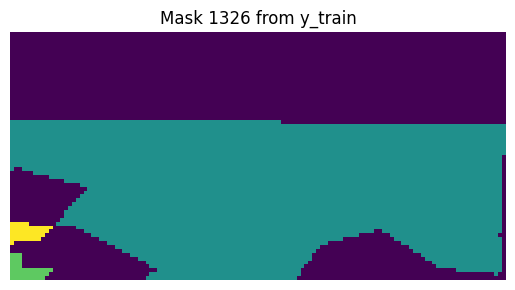

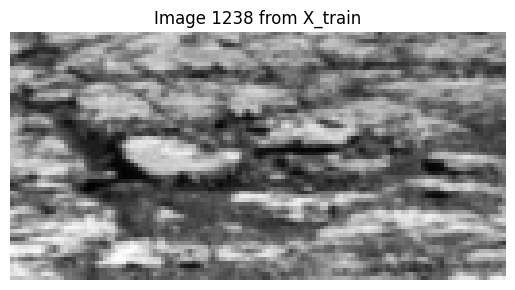

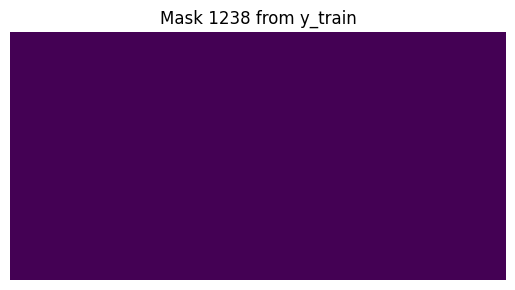

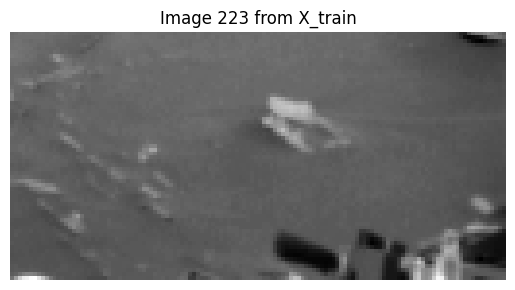

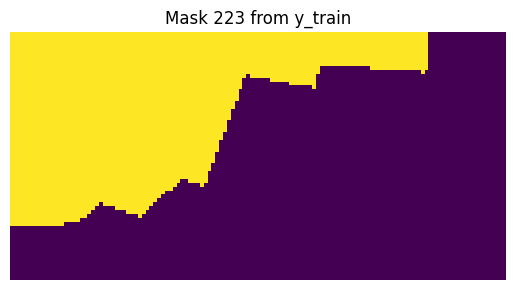

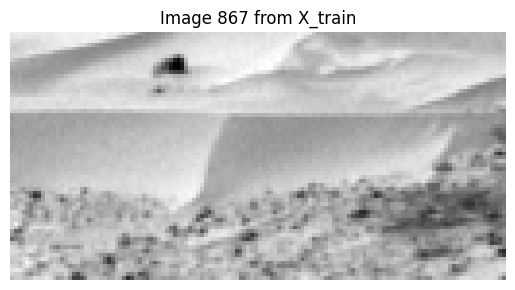

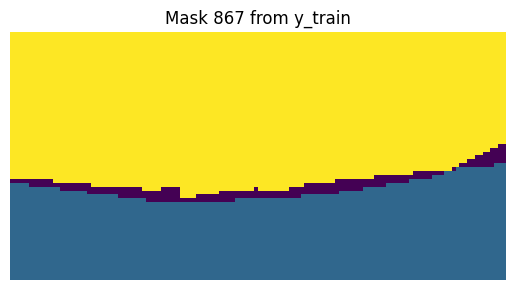

In [3]:
# Create a random index to display every time a different set of images
X_train_size = X_train.shape[0]
random_indices = np.random.randint(0, X_train_size, size = 10)
print(random_indices)

# Plot the image
for index in random_indices:
    plt.imshow(X_train[index], cmap='gray')
    plt.title(f"Image {index} from X_train")
    plt.axis('off')
    plt.show()
    
    plt.imshow(y_train[index])
    plt.title(f"Mask {index} from y_train")
    plt.axis('off')
    plt.show()

### 🧹 Remove the Outliers
Analysing the *X_train* and *y_train* sets, it is possible to notice some outliers. For example, there are some pictures (e.g. the one with index 62) contains the picture of an alien. 

By understanding both the pictures and the masks, the masks seems to be the same even if the alien picture is flipped. So we can scan all the masks that are the same of picture 62 and then remove them from the dataset.

In [4]:
# This function establish if image1 and image2 are the same images, pixel-wise.
def are_same_mask (image1, image2):
    if image1.shape != image2.shape:
        print("[ERROR] The images are not the same size.")
        return False
    return np.array_equal(image1, image2)

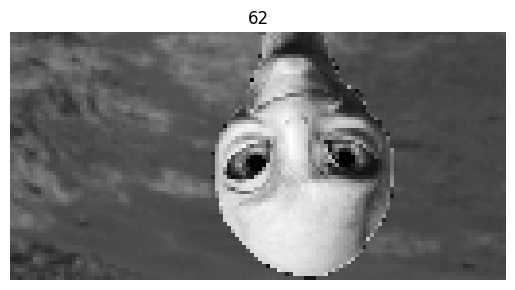

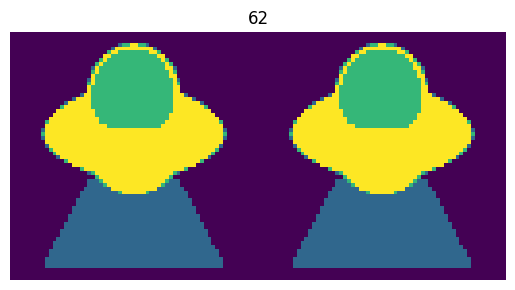

In [5]:
# Show the first picture of an alien
first_alien_index = 62
alien_indices = []
alien_indices.append(first_alien_index)

plt.imshow(X_train[first_alien_index], cmap='gray')
plt.title(first_alien_index)
plt.axis('off')
plt.show()

plt.imshow(y_train[first_alien_index])
plt.title(first_alien_index)
plt.axis('off')
plt.show()

In [6]:
# Detect all the images with the same masks as of the first alien
for i in range(X_train_size):
    if i != first_alien_index and are_same_mask(y_train[first_alien_index], y_train[i]):
        alien_indices.append(i)

print(f"{len(alien_indices)} images have the same mask of the first alien picture:")
print(alien_indices)

110 images have the same mask of the first alien picture:
[62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]


In [7]:
# Delete from X_train and y_train all the images with index in alien_indices
X_train = np.delete(X_train, alien_indices, axis=0)
y_train = np.delete(y_train, alien_indices, axis=0)

print("Shape of X_train without aliens: ", X_train.shape)
print("Shape of y_train without aliens: ", y_train.shape)

Shape of X_train without aliens:  (2505, 64, 128)
Shape of y_train without aliens:  (2505, 64, 128)


## 🪓 Split into training and validation set
The training set provided via the arrays *X_train* and *y_train* should be splitted into a new effective training set and a validation set.

In [8]:
# Split into training and validation set with a 80/20 ratio.
X_train, X_val, y_train, y_val = train_test_split (
    X_train, y_train, test_size = 0.2, random_state = seed
)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (2004, 64, 128)
y_train shape:  (2004, 64, 128)
X_val shape:  (501, 64, 128)
y_val shape:  (501, 64, 128)


## ☀️ Augmenting the training set
In this section we perform some static augmentations to the training set.

In [9]:
# Define a custom function for random horizontal/vertical flip
def random_flip (train_img, train_mask, threshold=0.5):
    for i in range(train_img.shape[0]):
        h_or_v = 0 if np.random.uniform(0, 1) < threshold else 1
        train_img[i] = cv2.flip(train_img[i], h_or_v)
        train_mask[i] = cv2.flip(train_mask[i], h_or_v)
    return train_img, train_mask

In [10]:
X_train_len = int(X_train.shape[0] * 1)

# Perform random horizontal/vertical flip on a copy of the first half of the dataset
X_train_flip = np.array(X_train[:X_train_len], copy = True)
y_train_flip = np.array(y_train[:X_train_len], copy = True)
X_train_copy, y_train_copy = random_flip(X_train_flip, y_train_flip)

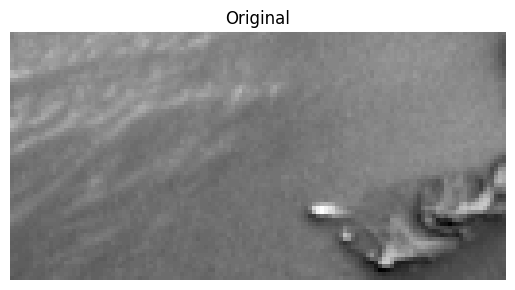

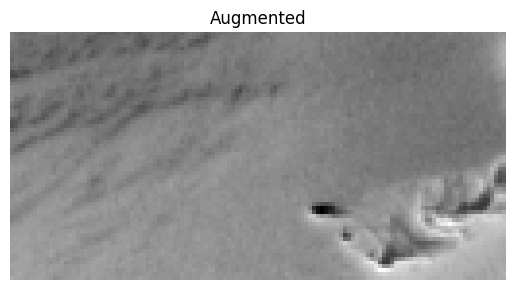

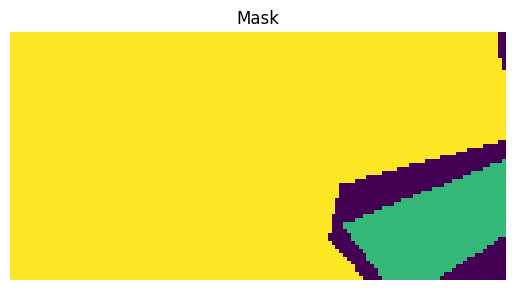

In [11]:
# Apply Solarization to a portion of the dataset
X_train_solar = np.array(X_train[:X_train_len], copy = True)
y_train_solar = np.array(y_train[:X_train_len], copy = True)

solarization = kcv.layers.Solarization(value_range=(0, 255))
X_train_solar = solarization(X_train_solar)

# Plot an example
# Display one random image and the corresponding mask containing an alien
rand_i = np.random.randint(0, X_train_solar.shape[0])

plt.imshow(X_train[rand_i], cmap='gray')
plt.title("Original")
plt.axis('off')
plt.show()

plt.imshow(X_train_solar[rand_i], cmap='gray')
plt.title("Augmented")
plt.axis('off')
plt.show()

plt.imshow(y_train_solar[rand_i])
plt.title("Mask")
plt.axis('off')
plt.show()

In [12]:
# Concatenate the obtained results
X_train = np.concatenate([X_train, X_train_flip], axis=0)
y_train = np.concatenate([y_train, y_train_flip], axis=0)

# print("X_train after flipping: ", X_train.shape)
# print("y_train after flipping: ", y_train.shape)

# Concatenate the obtained results
X_train = np.concatenate([X_train, X_train_solar], axis=0)
y_train = np.concatenate([y_train, y_train_solar], axis=0)

print("X_train after Solarization: ", X_train.shape)
print("y_train after Solarization: ", y_train.shape)

X_train after Solarization:  (6012, 64, 128)
y_train after Solarization:  (6012, 64, 128)


In [13]:
# Apply RandomContrast to the entire dataset
# rand_contrast = tfkl.RandomContrast(factor=0.3, seed=seed)
# X_train = rand_contrast(X_train)

In [14]:
# Apply RandomBrightness to the entire dataset
# rand_bn = tfkl.RandomBrightness(factor=0.2, value_range=(0, 255), seed=seed)
# X_train = rand_bn(X_train)

In [15]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# Retrieve the shape of the input
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


## 🛠️ Models and Experiments
A first experiment of the model is done by building from scratch the U-Net architecture.

In [16]:
# Define network hyperparameters
batch_size = 64
learning_rate = 1e-3
epochs = 100

print("Batch size: ", batch_size)
print("Initial learning rate: ", learning_rate)
print("Epochs: ", epochs)

Batch size:  64
Initial learning rate:  0.001
Epochs:  100


In [17]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [18]:
def get_unet_model(input_shape=(64, 128, 3), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 256, name='down_block3_')
    down_block_3 = tfkl.Dropout(0.5)(down_block_3)
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 512, name='bottleneck')
    bottleneck = tfkl.Dropout(0.5)(bottleneck)
    
    # Upsampling path
    u3 = tfkl.UpSampling2D()(bottleneck)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block(u3, 256, name='up_block3_')
    
    u2 = tfkl.UpSampling2D()(u3)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 128, name='up_block2_')

    u1 = tfkl.UpSampling2D()(u2)
    u1 = tfkl.Concatenate()([u1, down_block_1])
    u1 = unet_block(u1, 64, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,928 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,584 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 16, 32,  │   295,168 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 16, 32,  │     1,024 │ down_block3_c… │   Y 

 Total params: 7,793,285 (29.73 MB)

 Trainable params: 7,787,653 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

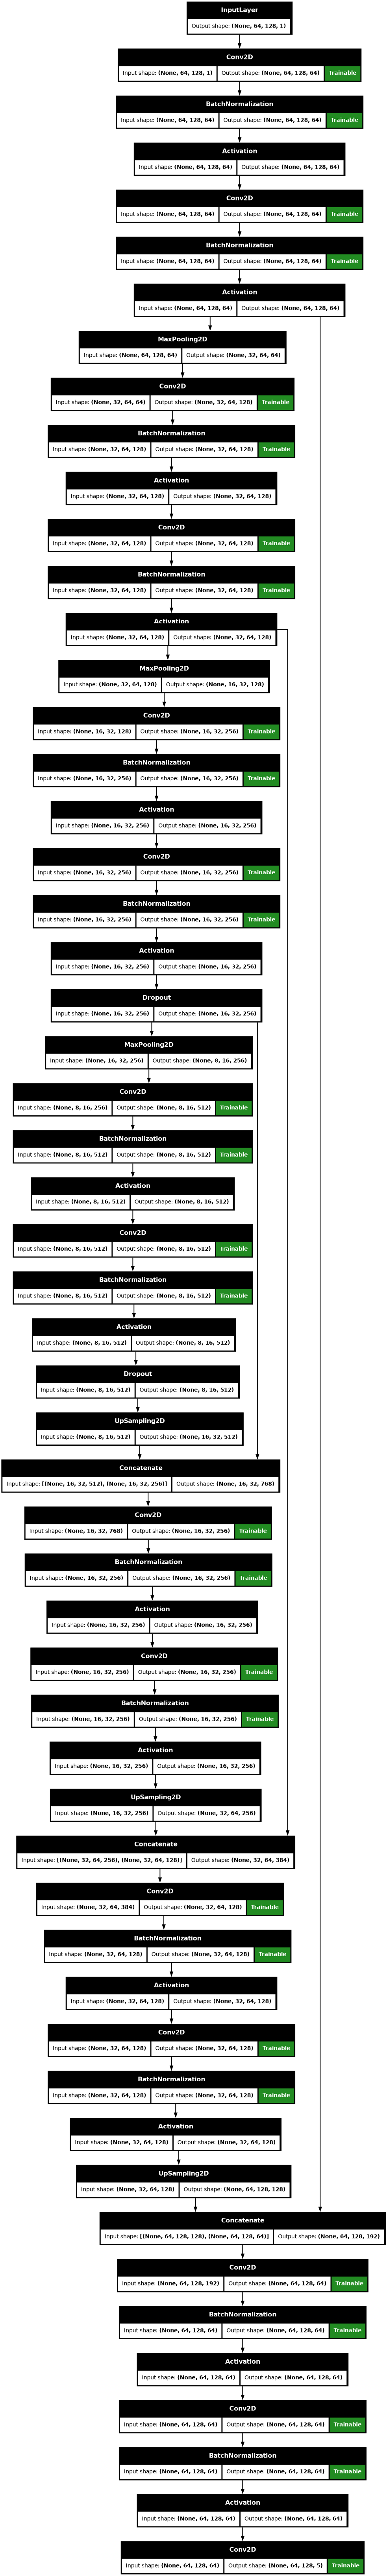

In [19]:
# Define the model
model = get_unet_model(input_shape=input_shape, num_classes=num_classes)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=False, show_shapes=True, dpi=70)

In [20]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [21]:
# Define custom Mean Intersection Over Union metric
# By default, no classes are excluded.
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_io_u", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [22]:
# Define the metric of mean intersection over union
# As suggested in the exercise session, a custom MeanIoU is suggested
# Class 0 (Background) is excluded from the computation of the MeanIoU, as reported in "Data" section
mean_iou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])

# Define the MeanIoU ignoring the background class
# mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

In [23]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, original_image, original_mask, num_classes, frequency=5):
        super().__init__()
        self.original_image = original_image   # Define the original image
        self.original_mask = original_mask     # Define the original mask
        self.num_classes = num_classes         # Define the number of classes
        self.frequency = frequency             # Define the visualization frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image = np.expand_dims(self.original_image, axis=0)  # Add batch dimension
            pred = self.model.predict(image, verbose=0)            
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.original_image, cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(apply_colormap(self.original_mask, colormap))
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred, colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()            

In [24]:
# Compile the model
print("Compiling model...")
model.compile (
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics=["accuracy", mean_iou]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [25]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping (
    monitor='val_mean_io_u',
    mode='max',
    patience=40,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau (
    monitor='val_loss',
    mode='min',
    patience=20,
    factor=0.1,
    min_lr=1e-6
)

random_viz = np.random.randint(0, X_val.shape[0])
print("Showing evolution on image", random_viz)
viz_callback = VizCallback(X_val[random_viz], y_val[random_viz], num_classes)

callbacks = [early_stopping, reduce_lr, viz_callback]

Showing evolution on image 149


Epoch 1/100


I0000 00:00:1733135970.984300      93 service.cc:145] XLA service 0x79adb4001d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733135970.984374      93 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1733135974.200133      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


  2/188 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.2661 - loss: 1.7745 - mean_io_u: 0.0896   

I0000 00:00:1733135990.520216      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3630 - loss: 1.3889 - mean_io_u: 0.1421

W0000 00:00:1733136009.952035      94 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.3632 - loss: 1.3884 - mean_io_u: 0.1423

W0000 00:00:1733136028.621780      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733136031.829645      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


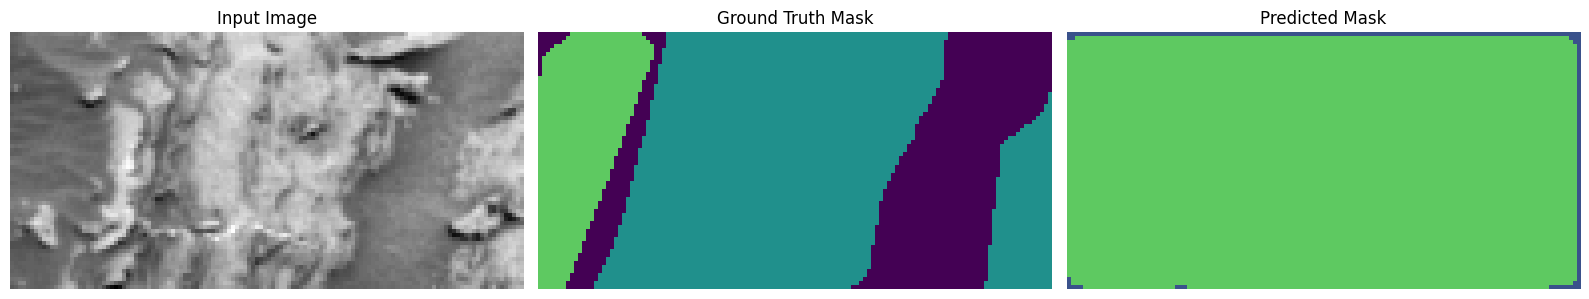

188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 244ms/step - accuracy: 0.3633 - loss: 1.3879 - mean_io_u: 0.1424 - val_accuracy: 0.2019 - val_loss: 2.1554 - val_mean_io_u: 0.0557 - learning_rate: 0.0010
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.4473 - loss: 1.1883 - mean_io_u: 0.1996 - val_accuracy: 0.2623 - val_loss: 2.1469 - val_mean_io_u: 0.0946 - learning_rate: 0.0010
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.5509 - loss: 1.0606 - mean_io_u: 0.2783 - val_accuracy: 0.4057 - val_loss: 1.5565 - val_mean_io_u: 0.1918 - learning_rate: 0.0010
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.6133 - loss: 0.9507 - mean_io_u: 0.3293 - val_accuracy: 0.6100 - val_loss: 1.0196 - val_mean_io_u: 0.3426 - learning_rate: 0.0010
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.6535 - loss: 0.8811 - mean_io_u: 0.3645 - val_accuracy: 0.5051 - val_loss: 1.2533 - val_mean_io_u: 0.2373 - learning_rate: 0.0010
Epoch 6/100
188/

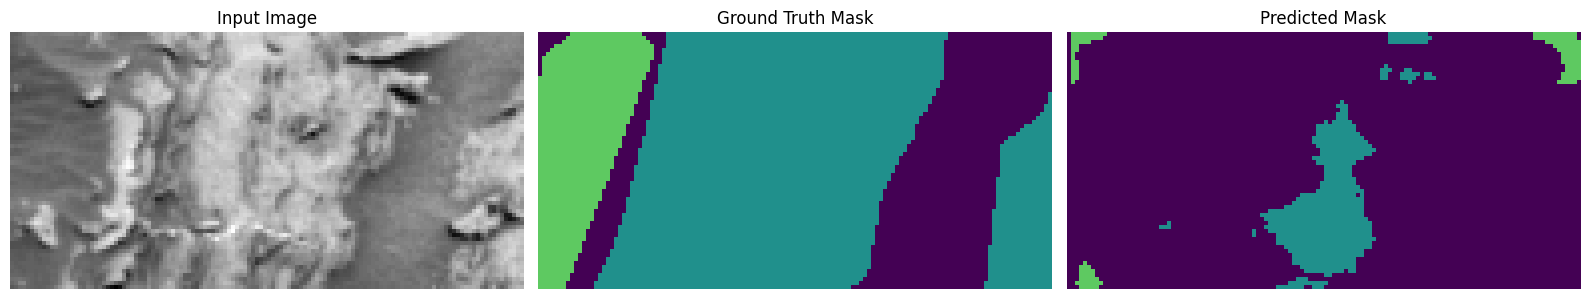

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.6627 - loss: 0.8587 - mean_io_u: 0.3719 - val_accuracy: 0.5770 - val_loss: 1.1285 - val_mean_io_u: 0.2747 - learning_rate: 0.0010
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.6765 - loss: 0.8260 - mean_io_u: 0.3830 - val_accuracy: 0.6618 - val_loss: 0.8691 - val_mean_io_u: 0.3667 - learning_rate: 0.0010
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.6862 - loss: 0.8032 - mean_io_u: 0.3911 - val_accuracy: 0.6025 - val_loss: 1.0645 - val_mean_io_u: 0.3063 - learning_rate: 0.0010
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.6949 - loss: 0.7832 - mean_io_u: 0.3983 - val_accuracy: 0.6824 - val_loss: 0.8090 - val_mean_io_u: 0.4177 - learning_rate: 0.0010
Epoch 10/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7105 - loss: 0.7511 - mean_io_u: 0.4117 - val_accuracy: 0.6190 - val_loss: 1.0188 - val_mean_io_u: 0.3020 - learning_rate: 0.0010
Epoch 11/100
188

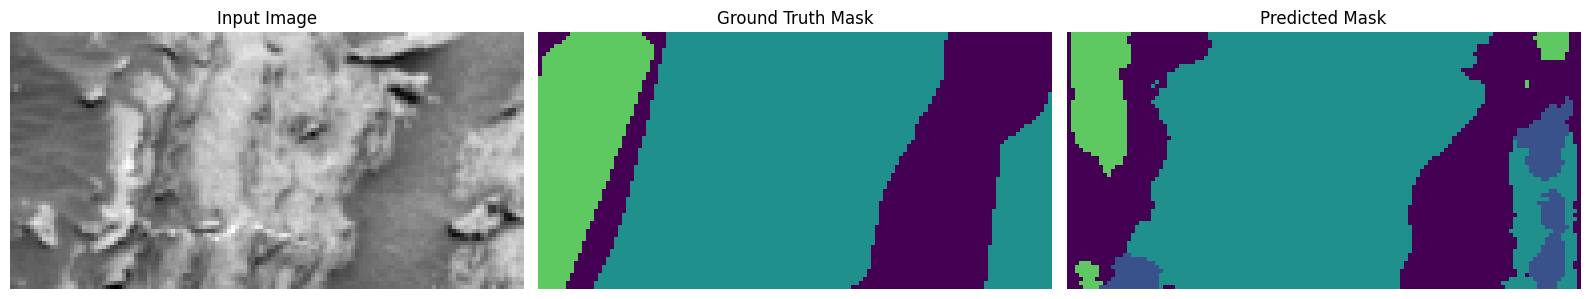

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.7102 - loss: 0.7468 - mean_io_u: 0.4106 - val_accuracy: 0.6957 - val_loss: 0.7853 - val_mean_io_u: 0.4117 - learning_rate: 0.0010
Epoch 12/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7210 - loss: 0.7243 - mean_io_u: 0.4221 - val_accuracy: 0.6418 - val_loss: 0.9886 - val_mean_io_u: 0.3307 - learning_rate: 0.0010
Epoch 13/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7275 - loss: 0.7043 - mean_io_u: 0.4269 - val_accuracy: 0.6786 - val_loss: 0.8296 - val_mean_io_u: 0.4132 - learning_rate: 0.0010
Epoch 14/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7322 - loss: 0.6928 - mean_io_u: 0.4329 - val_accuracy: 0.5996 - val_loss: 1.1083 - val_mean_io_u: 0.3242 - learning_rate: 0.0010
Epoch 15/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7344 - loss: 0.6851 - mean_io_u: 0.4336 - val_accuracy: 0.6345 - val_loss: 0.9871 - val_mean_io_u: 0.3320 - learning_rate: 0.0010
Epoch 16/100


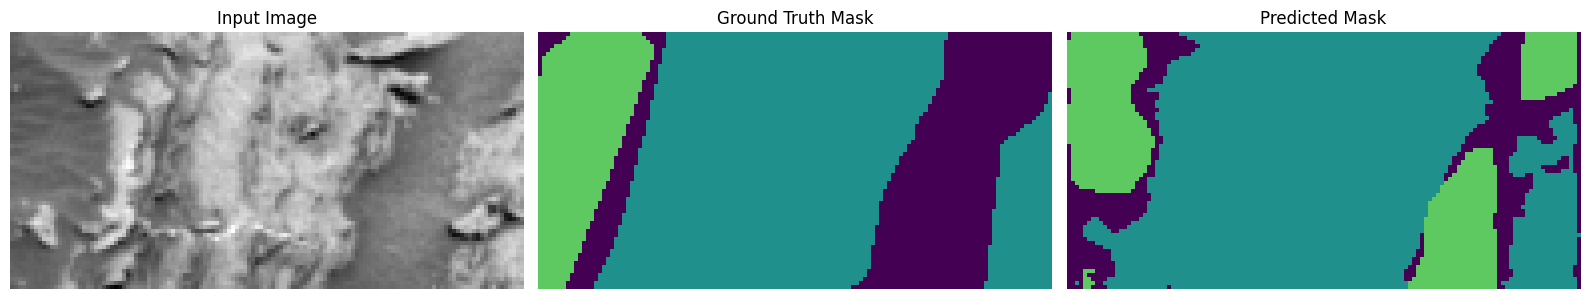

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.7374 - loss: 0.6732 - mean_io_u: 0.4353 - val_accuracy: 0.6804 - val_loss: 0.8441 - val_mean_io_u: 0.3949 - learning_rate: 0.0010
Epoch 17/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.7445 - loss: 0.6568 - mean_io_u: 0.4438 - val_accuracy: 0.6984 - val_loss: 0.7957 - val_mean_io_u: 0.4182 - learning_rate: 0.0010
Epoch 18/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7530 - loss: 0.6390 - mean_io_u: 0.4503 - val_accuracy: 0.6902 - val_loss: 0.8142 - val_mean_io_u: 0.3921 - learning_rate: 0.0010
Epoch 19/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7595 - loss: 0.6248 - mean_io_u: 0.4559 - val_accuracy: 0.5227 - val_loss: 1.3585 - val_mean_io_u: 0.2698 - learning_rate: 0.0010
Epoch 20/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7606 - loss: 0.6192 - mean_io_u: 0.4560 - val_accuracy: 0.6689 - val_loss: 0.8381 - val_mean_io_u: 0.3795 - learning_rate: 0.0010
Epoch 21/100


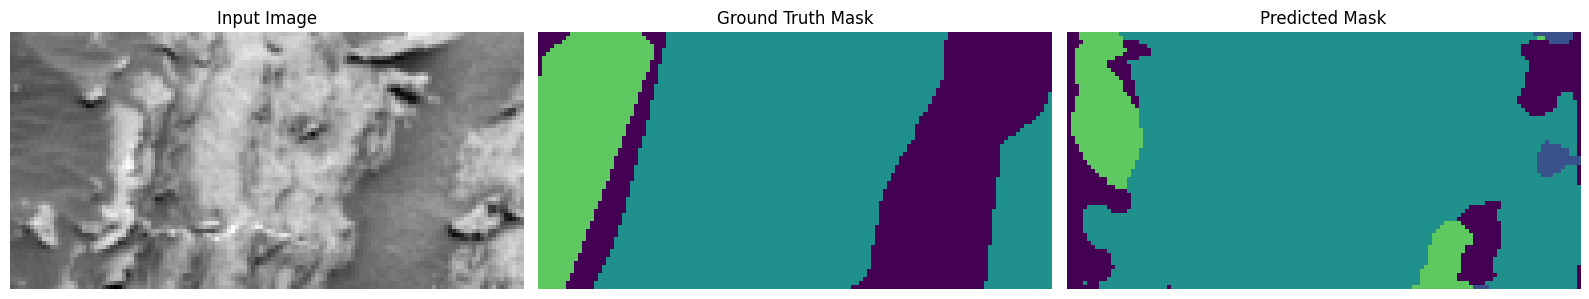

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.7661 - loss: 0.6031 - mean_io_u: 0.4608 - val_accuracy: 0.6966 - val_loss: 0.7756 - val_mean_io_u: 0.4124 - learning_rate: 0.0010
Epoch 22/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7703 - loss: 0.5929 - mean_io_u: 0.4659 - val_accuracy: 0.5680 - val_loss: 1.1910 - val_mean_io_u: 0.3157 - learning_rate: 0.0010
Epoch 23/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7734 - loss: 0.5862 - mean_io_u: 0.4682 - val_accuracy: 0.7088 - val_loss: 0.7574 - val_mean_io_u: 0.4422 - learning_rate: 0.0010
Epoch 24/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7784 - loss: 0.5787 - mean_io_u: 0.4719 - val_accuracy: 0.6592 - val_loss: 0.9156 - val_mean_io_u: 0.3890 - learning_rate: 0.0010
Epoch 25/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7821 - loss: 0.5663 - mean_io_u: 0.4736 - val_accuracy: 0.6642 - val_loss: 0.9064 - val_mean_io_u: 0.3837 - learning_rate: 0.0010
Epoch 26/100


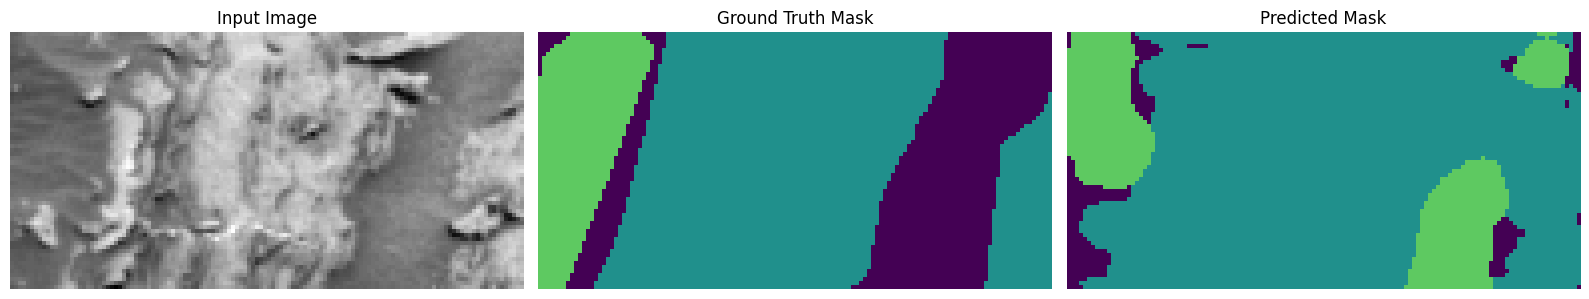

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.7885 - loss: 0.5468 - mean_io_u: 0.4799 - val_accuracy: 0.6948 - val_loss: 0.8062 - val_mean_io_u: 0.4250 - learning_rate: 0.0010
Epoch 27/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7928 - loss: 0.5375 - mean_io_u: 0.4836 - val_accuracy: 0.7026 - val_loss: 0.8199 - val_mean_io_u: 0.4301 - learning_rate: 0.0010
Epoch 28/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7969 - loss: 0.5254 - mean_io_u: 0.4888 - val_accuracy: 0.6942 - val_loss: 0.8189 - val_mean_io_u: 0.4362 - learning_rate: 0.0010
Epoch 29/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7998 - loss: 0.5195 - mean_io_u: 0.4910 - val_accuracy: 0.6982 - val_loss: 0.8275 - val_mean_io_u: 0.4213 - learning_rate: 0.0010
Epoch 30/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.8048 - loss: 0.5081 - mean_io_u: 0.4941 - val_accuracy: 0.7160 - val_loss: 0.7767 - val_mean_io_u: 0.4442 - learning_rate: 0.0010
Epoch 31/100


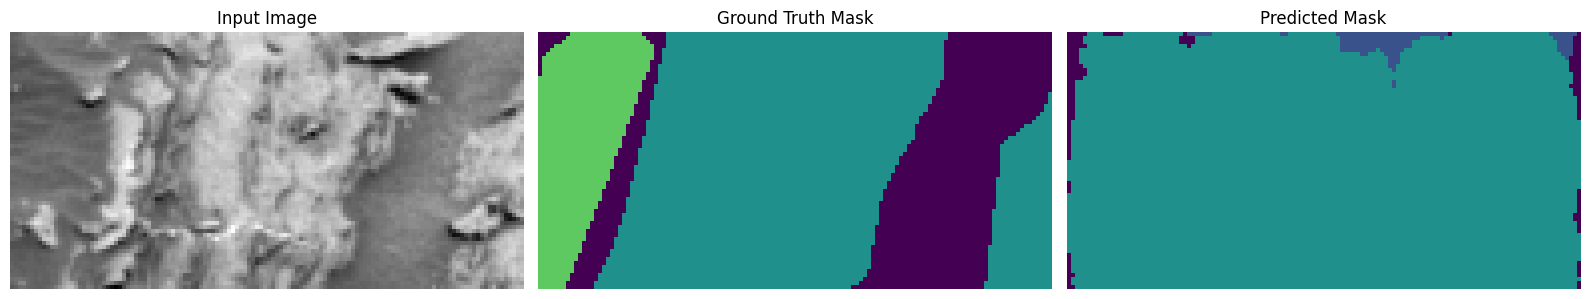

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.8104 - loss: 0.4947 - mean_io_u: 0.4982 - val_accuracy: 0.6429 - val_loss: 1.0062 - val_mean_io_u: 0.3668 - learning_rate: 0.0010
Epoch 32/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8134 - loss: 0.4858 - mean_io_u: 0.4999 - val_accuracy: 0.6967 - val_loss: 0.8983 - val_mean_io_u: 0.4615 - learning_rate: 0.0010
Epoch 33/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8195 - loss: 0.4720 - mean_io_u: 0.5042 - val_accuracy: 0.7235 - val_loss: 0.7615 - val_mean_io_u: 0.4620 - learning_rate: 0.0010
Epoch 34/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8288 - loss: 0.4511 - mean_io_u: 0.5120 - val_accuracy: 0.7104 - val_loss: 0.7974 - val_mean_io_u: 0.4474 - learning_rate: 0.0010
Epoch 35/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8360 - loss: 0.4296 - mean_io_u: 0.5188 - val_accuracy: 0.7178 - val_loss: 0.8132 - val_mean_io_u: 0.4679 - learning_rate: 0.0010
Epoch 36/100


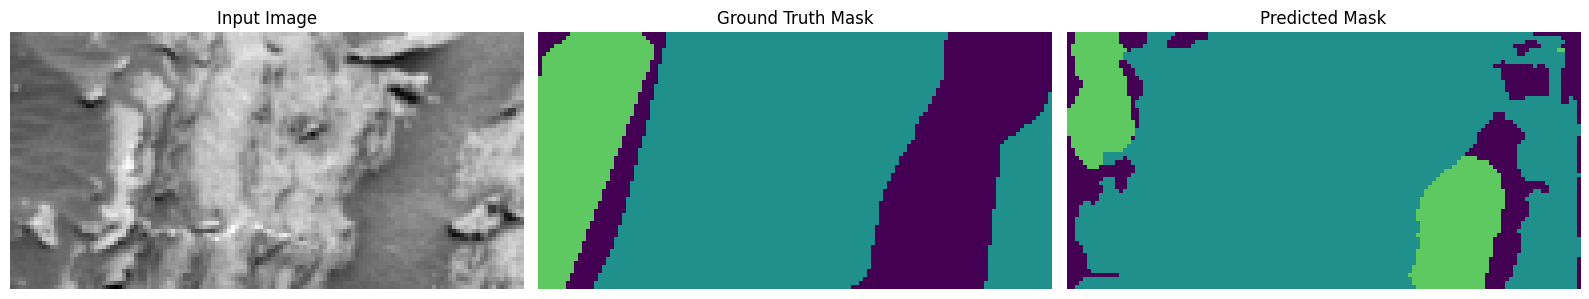

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.8388 - loss: 0.4211 - mean_io_u: 0.5197 - val_accuracy: 0.7216 - val_loss: 0.7548 - val_mean_io_u: 0.4509 - learning_rate: 0.0010
Epoch 37/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8392 - loss: 0.4234 - mean_io_u: 0.5193 - val_accuracy: 0.6795 - val_loss: 0.8587 - val_mean_io_u: 0.4167 - learning_rate: 0.0010
Epoch 38/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8496 - loss: 0.3956 - mean_io_u: 0.5276 - val_accuracy: 0.6529 - val_loss: 1.0555 - val_mean_io_u: 0.4037 - learning_rate: 0.0010
Epoch 39/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8560 - loss: 0.3792 - mean_io_u: 0.5329 - val_accuracy: 0.6687 - val_loss: 0.9536 - val_mean_io_u: 0.4053 - learning_rate: 0.0010
Epoch 40/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8593 - loss: 0.3688 - mean_io_u: 0.5333 - val_accuracy: 0.6768 - val_loss: 0.9428 - val_mean_io_u: 0.4151 - learning_rate: 0.0010
Epoch 41/100


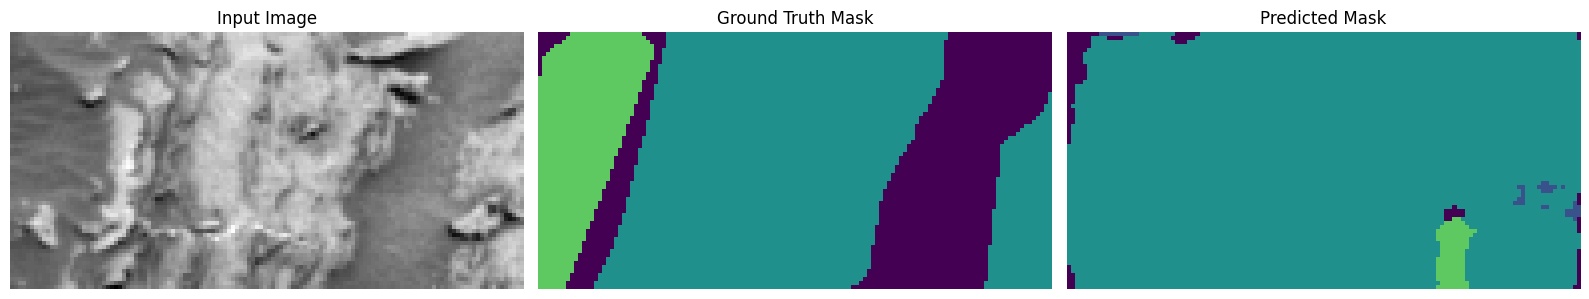

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.8625 - loss: 0.3603 - mean_io_u: 0.5347 - val_accuracy: 0.7003 - val_loss: 0.9028 - val_mean_io_u: 0.4341 - learning_rate: 0.0010
Epoch 42/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8695 - loss: 0.3438 - mean_io_u: 0.5395 - val_accuracy: 0.6790 - val_loss: 0.9689 - val_mean_io_u: 0.4113 - learning_rate: 0.0010
Epoch 43/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8708 - loss: 0.3407 - mean_io_u: 0.5408 - val_accuracy: 0.6991 - val_loss: 0.8706 - val_mean_io_u: 0.4475 - learning_rate: 0.0010
Epoch 44/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8818 - loss: 0.3112 - mean_io_u: 0.5493 - val_accuracy: 0.7105 - val_loss: 0.8889 - val_mean_io_u: 0.4654 - learning_rate: 0.0010
Epoch 45/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8792 - loss: 0.3144 - mean_io_u: 0.5482 - val_accuracy: 0.6911 - val_loss: 0.9366 - val_mean_io_u: 0.4459 - learning_rate: 0.0010
Epoch 46/100


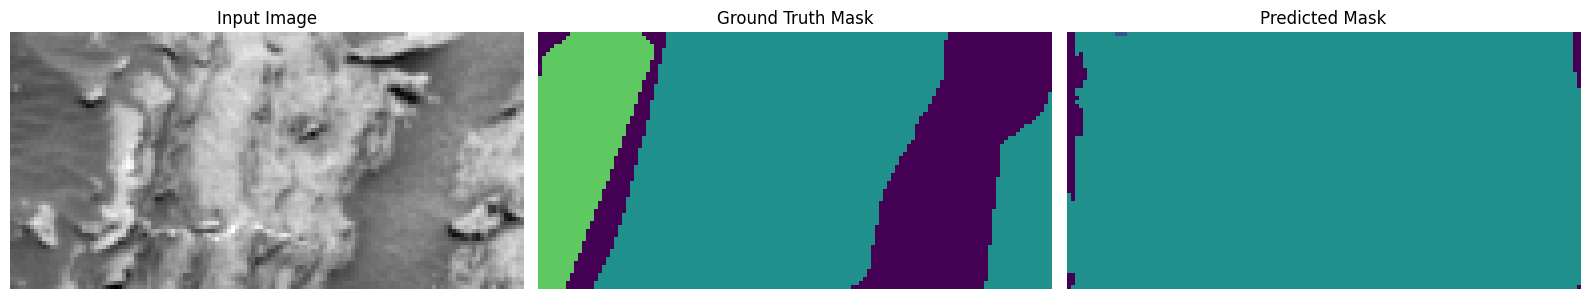

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.8850 - loss: 0.3007 - mean_io_u: 0.5536 - val_accuracy: 0.6973 - val_loss: 1.0047 - val_mean_io_u: 0.4614 - learning_rate: 0.0010
Epoch 47/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8968 - loss: 0.2704 - mean_io_u: 0.5653 - val_accuracy: 0.7068 - val_loss: 0.9863 - val_mean_io_u: 0.4612 - learning_rate: 0.0010
Epoch 48/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8995 - loss: 0.2634 - mean_io_u: 0.5687 - val_accuracy: 0.6831 - val_loss: 1.1439 - val_mean_io_u: 0.4506 - learning_rate: 0.0010
Epoch 49/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8951 - loss: 0.2739 - mean_io_u: 0.5659 - val_accuracy: 0.7069 - val_loss: 1.0333 - val_mean_io_u: 0.4593 - learning_rate: 0.0010
Epoch 50/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9011 - loss: 0.2636 - mean_io_u: 0.5716 - val_accuracy: 0.7010 - val_loss: 1.0602 - val_mean_io_u: 0.4260 - learning_rate: 0.0010
Epoch 51/100


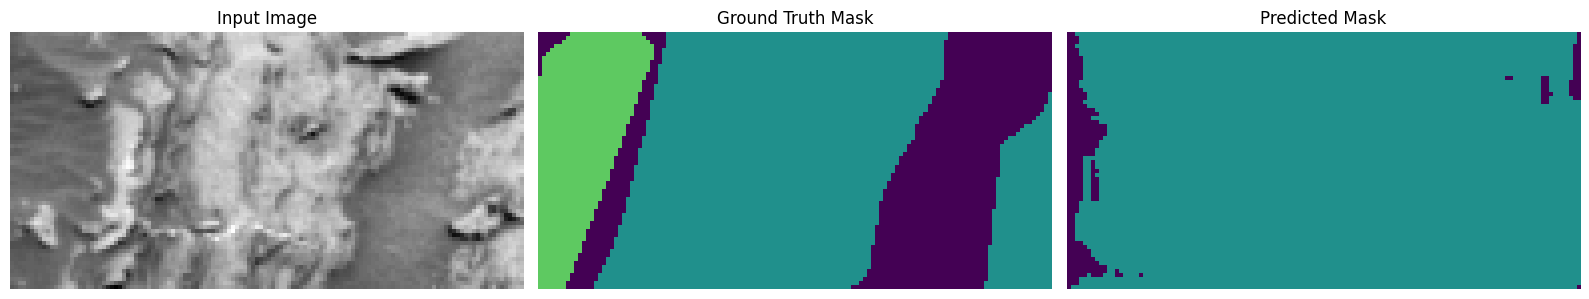

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9093 - loss: 0.2402 - mean_io_u: 0.5782 - val_accuracy: 0.7079 - val_loss: 1.0261 - val_mean_io_u: 0.4264 - learning_rate: 0.0010
Epoch 52/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9049 - loss: 0.2487 - mean_io_u: 0.5768 - val_accuracy: 0.6895 - val_loss: 1.2171 - val_mean_io_u: 0.4177 - learning_rate: 0.0010
Epoch 53/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9164 - loss: 0.2212 - mean_io_u: 0.5869 - val_accuracy: 0.7035 - val_loss: 1.1716 - val_mean_io_u: 0.4138 - learning_rate: 0.0010
Epoch 54/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9179 - loss: 0.2161 - mean_io_u: 0.5990 - val_accuracy: 0.6711 - val_loss: 1.3432 - val_mean_io_u: 0.3965 - learning_rate: 0.0010
Epoch 55/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9126 - loss: 0.2306 - mean_io_u: 0.5901 - val_accuracy: 0.6678 - val_loss: 1.3689 - val_mean_io_u: 0.3946 - learning_rate: 0.0010
Epoch 56/100


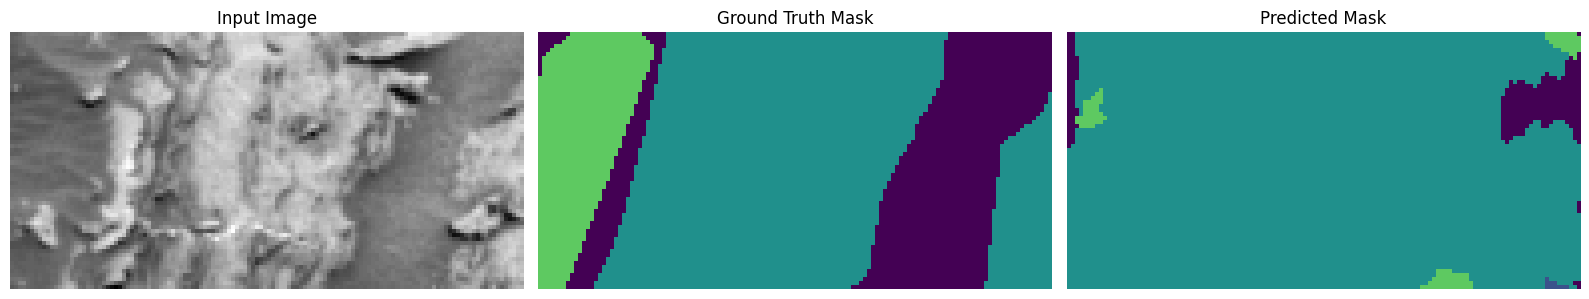

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9209 - loss: 0.2082 - mean_io_u: 0.5996 - val_accuracy: 0.7180 - val_loss: 1.2488 - val_mean_io_u: 0.4348 - learning_rate: 0.0010
Epoch 57/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9188 - loss: 0.2173 - mean_io_u: 0.6050 - val_accuracy: 0.7674 - val_loss: 0.8677 - val_mean_io_u: 0.4968 - learning_rate: 1.0000e-04
Epoch 58/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9346 - loss: 0.1720 - mean_io_u: 0.6276 - val_accuracy: 0.7675 - val_loss: 0.8850 - val_mean_io_u: 0.4981 - learning_rate: 1.0000e-04
Epoch 59/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9384 - loss: 0.1628 - mean_io_u: 0.6306 - val_accuracy: 0.7665 - val_loss: 0.9128 - val_mean_io_u: 0.4981 - learning_rate: 1.0000e-04
Epoch 60/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9403 - loss: 0.1565 - mean_io_u: 0.6337 - val_accuracy: 0.7660 - val_loss: 0.9303 - val_mean_io_u: 0.4981 - learning_rate: 1.0000e-

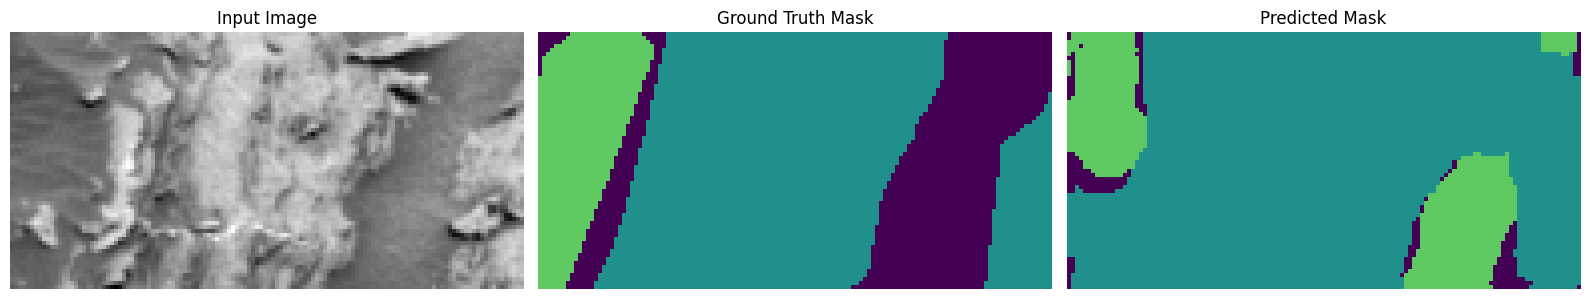

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9424 - loss: 0.1517 - mean_io_u: 0.6328 - val_accuracy: 0.7663 - val_loss: 0.9463 - val_mean_io_u: 0.4987 - learning_rate: 1.0000e-04
Epoch 62/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9434 - loss: 0.1487 - mean_io_u: 0.6363 - val_accuracy: 0.7655 - val_loss: 0.9618 - val_mean_io_u: 0.4998 - learning_rate: 1.0000e-04
Epoch 63/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.9450 - loss: 0.1449 - mean_io_u: 0.6383 - val_accuracy: 0.7677 - val_loss: 0.9543 - val_mean_io_u: 0.5029 - learning_rate: 1.0000e-04
Epoch 64/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9455 - loss: 0.1429 - mean_io_u: 0.6361 - val_accuracy: 0.7663 - val_loss: 0.9689 - val_mean_io_u: 0.5012 - learning_rate: 1.0000e-04
Epoch 65/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9472 - loss: 0.1386 - mean_io_u: 0.6463 - val_accuracy: 0.7671 - val_loss: 0.9770 - val_mean_io_u: 0.5022 - learning_rate: 1.00

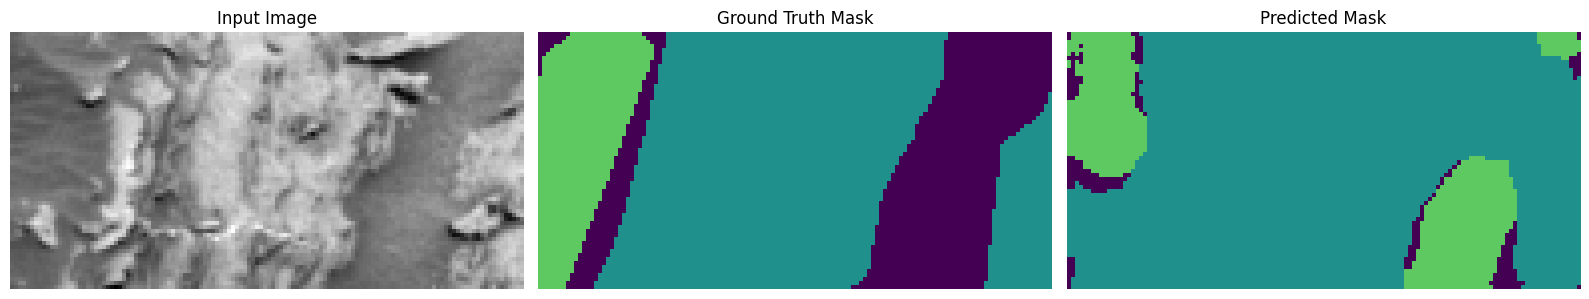

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9479 - loss: 0.1363 - mean_io_u: 0.6464 - val_accuracy: 0.7672 - val_loss: 0.9836 - val_mean_io_u: 0.5031 - learning_rate: 1.0000e-04
Epoch 67/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9491 - loss: 0.1335 - mean_io_u: 0.6443 - val_accuracy: 0.7668 - val_loss: 0.9939 - val_mean_io_u: 0.5008 - learning_rate: 1.0000e-04
Epoch 68/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9497 - loss: 0.1319 - mean_io_u: 0.6508 - val_accuracy: 0.7678 - val_loss: 1.0060 - val_mean_io_u: 0.5017 - learning_rate: 1.0000e-04
Epoch 69/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9503 - loss: 0.1297 - mean_io_u: 0.6478 - val_accuracy: 0.7669 - val_loss: 1.0086 - val_mean_io_u: 0.5021 - learning_rate: 1.0000e-04
Epoch 70/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.9511 - loss: 0.1275 - mean_io_u: 0.6488 - val_accuracy: 0.7690 - val_loss: 1.0196 - val_mean_io_u: 0.5033 - learning_rate: 1.00

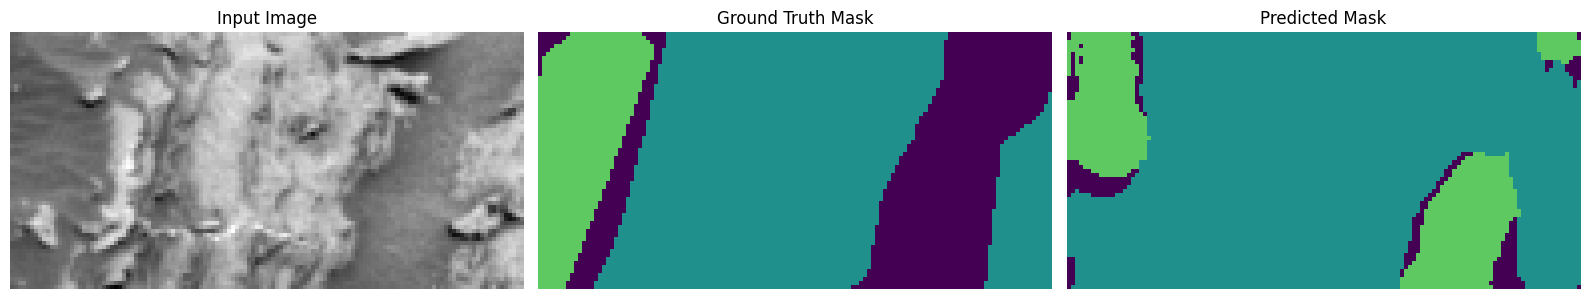

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.9518 - loss: 0.1258 - mean_io_u: 0.6569 - val_accuracy: 0.7695 - val_loss: 1.0147 - val_mean_io_u: 0.5058 - learning_rate: 1.0000e-04
Epoch 72/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9525 - loss: 0.1231 - mean_io_u: 0.6619 - val_accuracy: 0.7697 - val_loss: 1.0293 - val_mean_io_u: 0.5049 - learning_rate: 1.0000e-04
Epoch 73/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9533 - loss: 0.1214 - mean_io_u: 0.6638 - val_accuracy: 0.7680 - val_loss: 1.0406 - val_mean_io_u: 0.5036 - learning_rate: 1.0000e-04
Epoch 74/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9534 - loss: 0.1210 - mean_io_u: 0.6597 - val_accuracy: 0.7687 - val_loss: 1.0461 - val_mean_io_u: 0.5004 - learning_rate: 1.0000e-04
Epoch 75/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9543 - loss: 0.1186 - mean_io_u: 0.6623 - val_accuracy: 0.7674 - val_loss: 1.0695 - val_mean_io_u: 0.5042 - learning_rate: 1.00

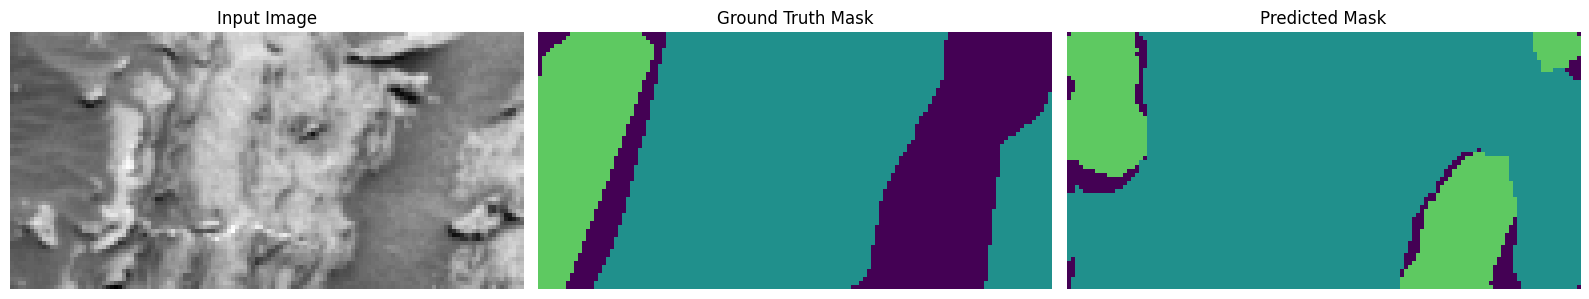

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9545 - loss: 0.1176 - mean_io_u: 0.6653 - val_accuracy: 0.7691 - val_loss: 1.0613 - val_mean_io_u: 0.5064 - learning_rate: 1.0000e-04
Epoch 77/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9541 - loss: 0.1187 - mean_io_u: 0.6662 - val_accuracy: 0.7714 - val_loss: 1.0159 - val_mean_io_u: 0.5079 - learning_rate: 1.0000e-05
Epoch 78/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9550 - loss: 0.1163 - mean_io_u: 0.6770 - val_accuracy: 0.7713 - val_loss: 1.0237 - val_mean_io_u: 0.5077 - learning_rate: 1.0000e-05
Epoch 79/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.9554 - loss: 0.1155 - mean_io_u: 0.6731 - val_accuracy: 0.7715 - val_loss: 1.0260 - val_mean_io_u: 0.5085 - learning_rate: 1.0000e-05
Epoch 80/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.9555 - loss: 0.1147 - mean_io_u: 0.6689 - val_accuracy: 0.7716 - val_loss: 1.0306 - val_mean_io_u: 0.5094 - learning_rate: 1.00

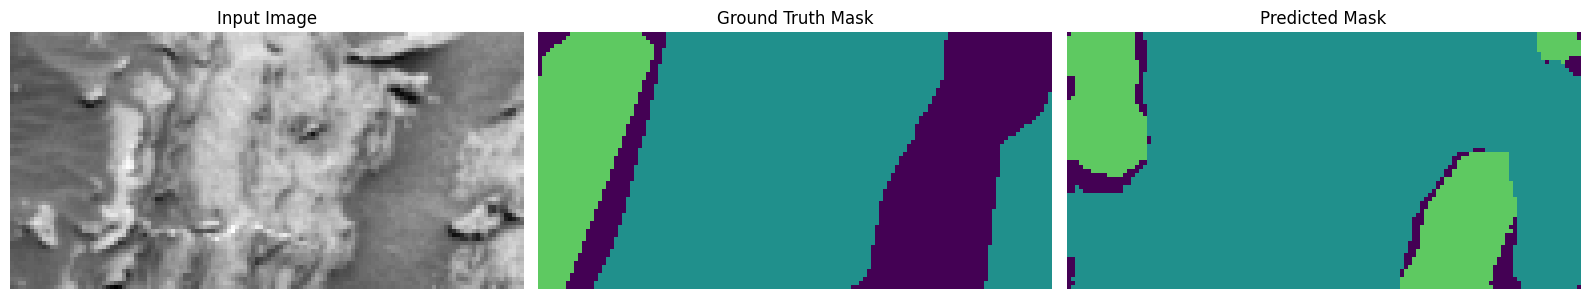

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9560 - loss: 0.1133 - mean_io_u: 0.6727 - val_accuracy: 0.7711 - val_loss: 1.0346 - val_mean_io_u: 0.5090 - learning_rate: 1.0000e-05
Epoch 82/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.9561 - loss: 0.1131 - mean_io_u: 0.6721 - val_accuracy: 0.7711 - val_loss: 1.0361 - val_mean_io_u: 0.5099 - learning_rate: 1.0000e-05
Epoch 83/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9562 - loss: 0.1126 - mean_io_u: 0.6771 - val_accuracy: 0.7720 - val_loss: 1.0374 - val_mean_io_u: 0.5098 - learning_rate: 1.0000e-05
Epoch 84/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9563 - loss: 0.1131 - mean_io_u: 0.6725 - val_accuracy: 0.7718 - val_loss: 1.0399 - val_mean_io_u: 0.5097 - learning_rate: 1.0000e-05
Epoch 85/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9563 - loss: 0.1127 - mean_io_u: 0.6742 - val_accuracy: 0.7719 - val_loss: 1.0365 - val_mean_io_u: 0.5100 - learning_rate: 1.00

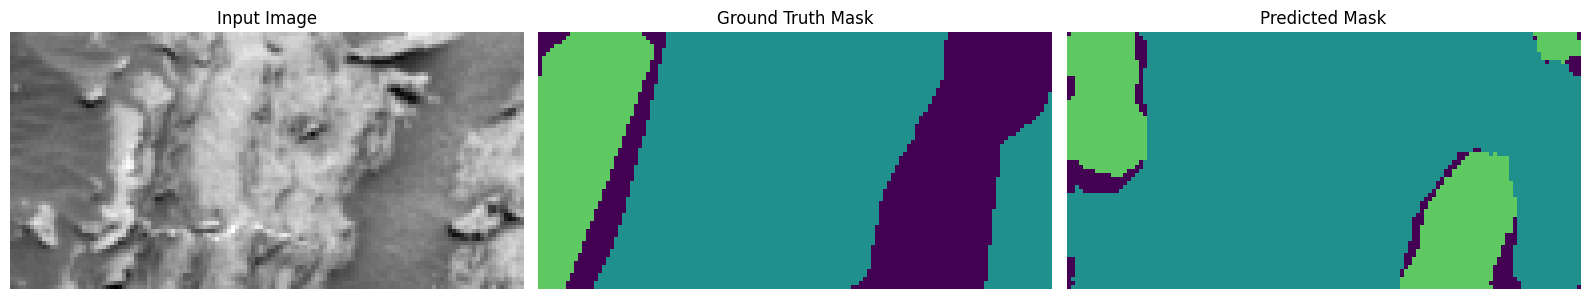

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9562 - loss: 0.1130 - mean_io_u: 0.6750 - val_accuracy: 0.7718 - val_loss: 1.0436 - val_mean_io_u: 0.5104 - learning_rate: 1.0000e-05
Epoch 87/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9562 - loss: 0.1126 - mean_io_u: 0.6740 - val_accuracy: 0.7714 - val_loss: 1.0435 - val_mean_io_u: 0.5105 - learning_rate: 1.0000e-05
Epoch 88/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9563 - loss: 0.1122 - mean_io_u: 0.6728 - val_accuracy: 0.7718 - val_loss: 1.0443 - val_mean_io_u: 0.5105 - learning_rate: 1.0000e-05
Epoch 89/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9567 - loss: 0.1114 - mean_io_u: 0.6756 - val_accuracy: 0.7714 - val_loss: 1.0450 - val_mean_io_u: 0.5106 - learning_rate: 1.0000e-05
Epoch 90/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9570 - loss: 0.1108 - mean_io_u: 0.6727 - val_accuracy: 0.7711 - val_loss: 1.0469 - val_mean_io_u: 0.5108 - learning_rate: 1.00

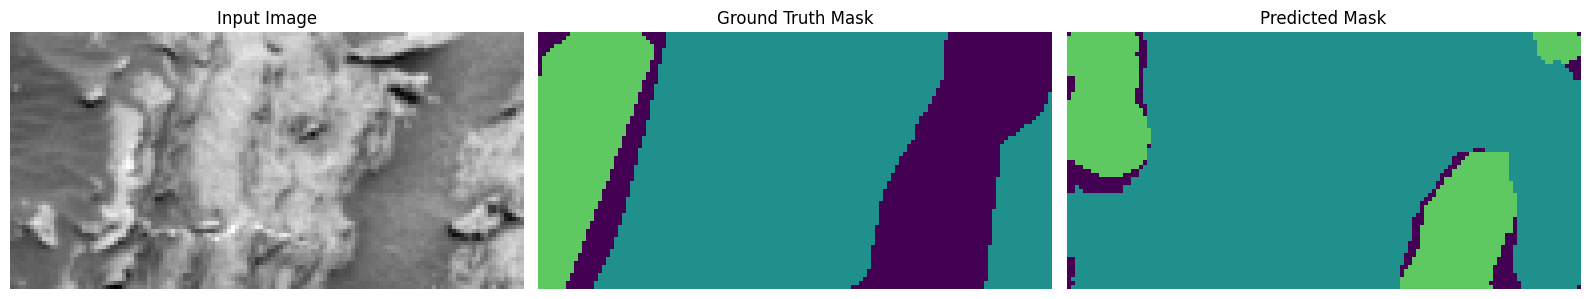

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9568 - loss: 0.1116 - mean_io_u: 0.6751 - val_accuracy: 0.7721 - val_loss: 1.0464 - val_mean_io_u: 0.5104 - learning_rate: 1.0000e-05
Epoch 92/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9570 - loss: 0.1110 - mean_io_u: 0.6806 - val_accuracy: 0.7716 - val_loss: 1.0484 - val_mean_io_u: 0.5098 - learning_rate: 1.0000e-05
Epoch 93/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9567 - loss: 0.1115 - mean_io_u: 0.6793 - val_accuracy: 0.7717 - val_loss: 1.0522 - val_mean_io_u: 0.5103 - learning_rate: 1.0000e-05
Epoch 94/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9570 - loss: 0.1108 - mean_io_u: 0.6820 - val_accuracy: 0.7717 - val_loss: 1.0501 - val_mean_io_u: 0.5087 - learning_rate: 1.0000e-05
Epoch 95/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9570 - loss: 0.1108 - mean_io_u: 0.6791 - val_accuracy: 0.7723 - val_loss: 1.0497 - val_mean_io_u: 0.5099 - learning_rate: 1.00

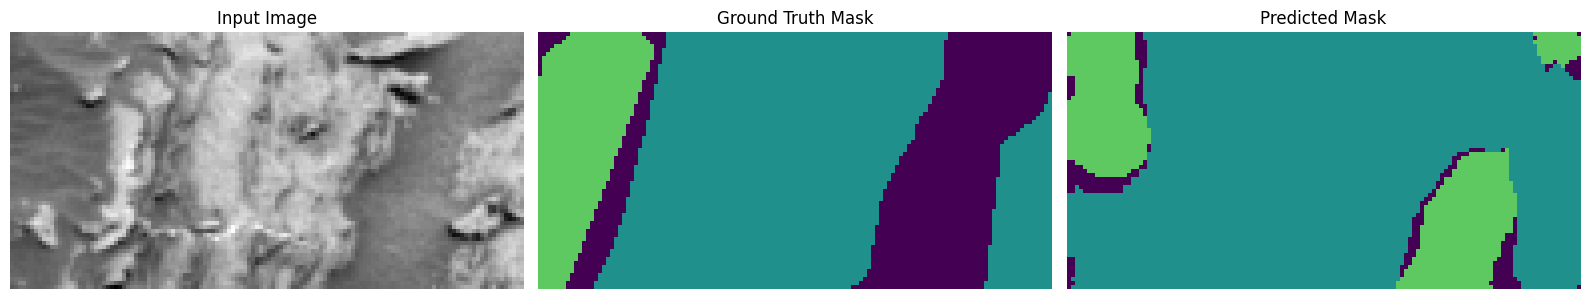

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9573 - loss: 0.1102 - mean_io_u: 0.6783 - val_accuracy: 0.7720 - val_loss: 1.0527 - val_mean_io_u: 0.5100 - learning_rate: 1.0000e-05
Epoch 97/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9571 - loss: 0.1108 - mean_io_u: 0.6721 - val_accuracy: 0.7726 - val_loss: 1.0441 - val_mean_io_u: 0.5106 - learning_rate: 1.0000e-06
Epoch 98/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9573 - loss: 0.1099 - mean_io_u: 0.6736 - val_accuracy: 0.7726 - val_loss: 1.0431 - val_mean_io_u: 0.5106 - learning_rate: 1.0000e-06
Epoch 99/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9573 - loss: 0.1100 - mean_io_u: 0.6837 - val_accuracy: 0.7725 - val_loss: 1.0425 - val_mean_io_u: 0.5105 - learning_rate: 1.0000e-06
Epoch 100/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9570 - loss: 0.1101 - mean_io_u: 0.6667 - val_accuracy: 0.7724 - val_loss: 1.0443 - val_mean_io_u: 0.5103 - learning_rate: 1.0

In [26]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

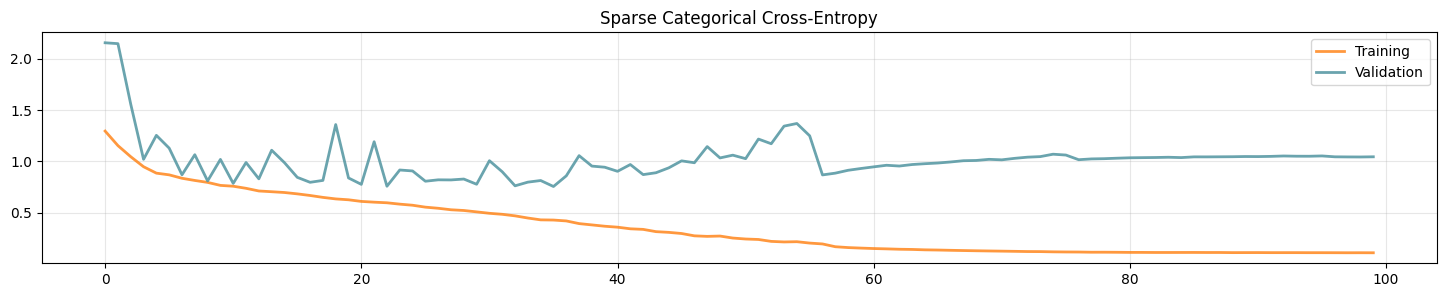

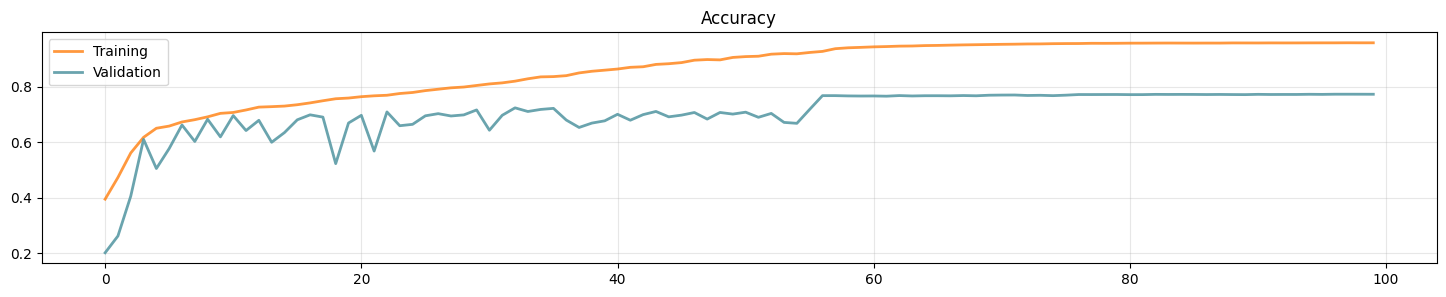

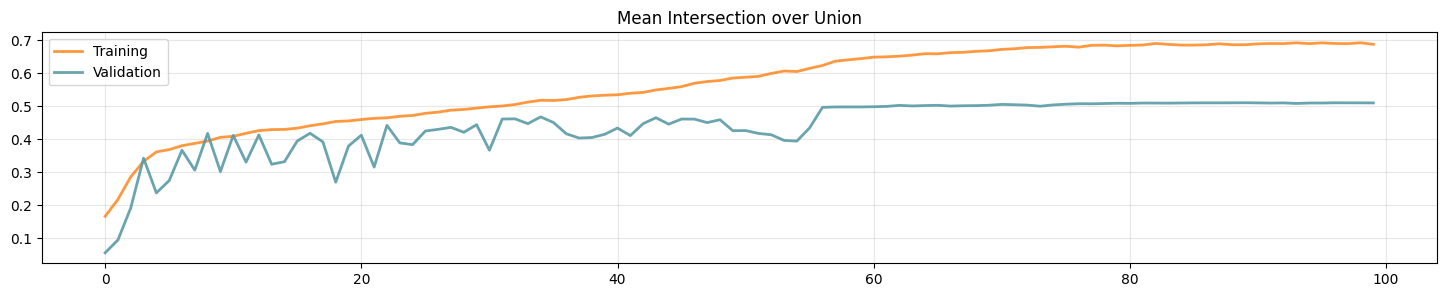

In [27]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Sparse Categorical Cross-Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [28]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241202_110923.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.

In [35]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [36]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241202_110923.keras


In [37]:
# Custom compiling due to custom metric MeanIOU defined
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

In [38]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step
Predictions shape: (10022, 64, 128)


In [39]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [40]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

print("CSV created in the output folder: ", submission_filename)

CSV created in the output folder:  submission_241202_110923.csv
